In [1]:
"""
File: AttentionVisualization.ipynb
---------------------------------
Visualize the attention layers of transformer models for interpretability.
"""

'\nFile: AttentionVisualization.py\n---------------------------------\nVisualize the attention layers of transformer models for interpretability.\n'

In [34]:
import os
import sys
from typing import Any, Dict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pytorch_lightning as pl
import torch
from torch.utils.data import Subset
from lightning.pytorch.loggers import WandbLogger
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from pytorch_lightning.strategies.ddp import DDPStrategy
from pytorch_lightning.strategies import DeepSpeedStrategy
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Subset

ROOT = "/fs01/home/afallah/odyssey/odyssey"
os.chdir(ROOT)

from lib.data import FinetuneDataset
from lib.tokenizer import ConceptTokenizer
from lib.utils import (
    get_run_id,
    load_config,
    load_finetune_data,
    seed_everything,
)
from lib.prediction import load_finetuned_model, predict_patient_outcomes
from models.big_bird_cehr.model import BigBirdFinetune, BigBirdPretrain
from models.cehr_bert.model import BertFinetune, BertPretrain

In [3]:
class args:
    """Save the configuration arguments."""

    model_path = (
        "checkpoints/bigbird_finetune/mortality_1month_20000_patients/best-v3.ckpt"
    )
    vocab_dir = "data/vocab"
    data_dir = "data/bigbird_data"
    sequence_file = "patient_sequences/patient_sequences_2048_mortality.parquet"
    id_file = "patient_id_dict/dataset_2048_mortality_1month.pkl"
    valid_scheme = "few_shot"
    num_finetune_patients = "20000"
    label_name = "label_mortality_1month"

    max_len = 2048
    batch_size = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
tokenizer = ConceptTokenizer(data_dir=args.vocab_dir)
tokenizer.fit_on_vocab()

In [6]:
model = load_finetuned_model(args.model_path, tokenizer)
model

BigBirdFinetune(
  (model): BigBirdForSequenceClassification(
    (bert): BigBirdModel(
      (embeddings): BigBirdEmbeddingsForCEHR(
        (word_embeddings): Embedding(20592, 768, padding_idx=0)
        (position_embeddings): Embedding(2048, 768)
        (token_type_embeddings): Embedding(9, 768)
        (time_embeddings): TimeEmbeddingLayer()
        (age_embeddings): TimeEmbeddingLayer()
        (visit_segment_embeddings): VisitEmbedding(
          (embedding): Embedding(3, 768)
        )
        (scale_back_concat_layer): Linear(in_features=832, out_features=768, bias=True)
        (tanh): Tanh()
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BigBirdEncoder(
        (layer): ModuleList(
          (0-5): 6 x BigBirdLayer(
            (attention): BigBirdAttention(
              (self): BigBirdBlockSparseAttention(
                (query): Linear(in_features=768, out_features=768, 

In [51]:
fine_tune, fine_test = load_finetune_data(
    args.data_dir,
    args.sequence_file,
    args.id_file,
    args.valid_scheme,
    args.num_finetune_patients,
)

fine_tune.rename(columns={args.label_name: "label"}, inplace=True)
fine_test.rename(columns={args.label_name: "label"}, inplace=True)

In [ ]:
test_dataset = FinetuneDataset(
    data=fine_test,
    tokenizer=tokenizer,
    max_len=args.max_len,
)

test_loader = DataLoader(
    Subset(test_dataset, [40, 41]),
    batch_size=args.batch_size,
)

In [52]:
patient = next(iter(test_loader))
patient

{'concept_ids': tensor([[    5,     3, 17685,  ...,  1712,     4,     6]]),
 'type_ids': tensor([[1, 2, 6,  ..., 5, 3, 8]]),
 'ages': tensor([[ 0, 83, 83,  ..., 84, 84, 84]]),
 'time_stamps': tensor([[   0, 5736, 5736,  ..., 5789, 5789, 5789]]),
 'visit_orders': tensor([[ 0,  2,  2,  ..., 11, 11, 11]]),
 'visit_segments': tensor([[0, 2, 2,  ..., 1, 1, 1]]),
 'labels': tensor([1]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])}

In [53]:
output = predict_patient_outcomes(patient, model)
output

SequenceClassifierOutput(loss=tensor(0.1277, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[-1.2446,  0.7492]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=(tensor([[[-0.6737, -0.4033, -1.0631,  ..., -0.0571, -0.5688, -2.8107],
         [-0.0033,  2.1070, -0.4193,  ...,  1.2407, -1.5026, -0.8834],
         [-0.8628, -0.3004,  0.6597,  ...,  1.2252, -1.3675,  0.3138],
         ...,
         [-0.8319, -0.2234,  0.0291,  ..., -0.1277,  0.2698, -0.5756],
         [ 2.1574,  0.9756, -0.4444,  ...,  0.4462, -0.9286, -1.7470],
         [-0.1750,  0.1480,  0.2137,  ..., -0.4880, -2.0789,  0.4948]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>), tensor([[[-0.6056,  0.5179, -0.0994,  ..., -0.1724, -0.5481, -2.1398],
         [-0.1889,  1.7078, -0.0960,  ...,  0.8114, -1.2664, -1.1706],
         [-0.6965,  0.0508,  0.0892,  ...,  0.3491, -1.3607, -0.2644],
         ...,
         [-0.2425, -0.1158, -0.1217,  ..., -0.3325, -0.7541, -0.2991],
         [ 1.

In [54]:
last_attention_matrix = output["attentions"][-1].detach()
# batch_size x num_heads x max_len x max_len    x num_layers

Token [W_0] with Token [CLS]: Attention Value 0.08492616564035416
Token 0045 with Token [CLS]: Attention Value 0.06910177320241928
Token 50882_4 with Token [CLS]: Attention Value 0.06804924458265305
Token 51222_3 with Token [CLS]: Attention Value 0.06692373007535934
Token 8857 with Token [CLS]: Attention Value 0.06530807912349701
Token 51006_3 with Token [CLS]: Attention Value 0.06496138125658035
Token [W_0] with Token [CLS]: Attention Value 0.06492725014686584
Token 50912_2 with Token [CLS]: Attention Value 0.06410873681306839
Token 51275_4 with Token [CLS]: Attention Value 0.06330996006727219
Token 50902_0 with Token [CLS]: Attention Value 0.06244368851184845
Token 51275_4 with Token [CLS]: Attention Value 0.05997256934642792
Token 51248_1 with Token [CLS]: Attention Value 0.057016339153051376
Token 50960_2 with Token [CLS]: Attention Value 0.05684155225753784
Token 51279_3 with Token [CLS]: Attention Value 0.056462764739990234
Token 63739002401 with Token [CLS]: Attention Value 0.05

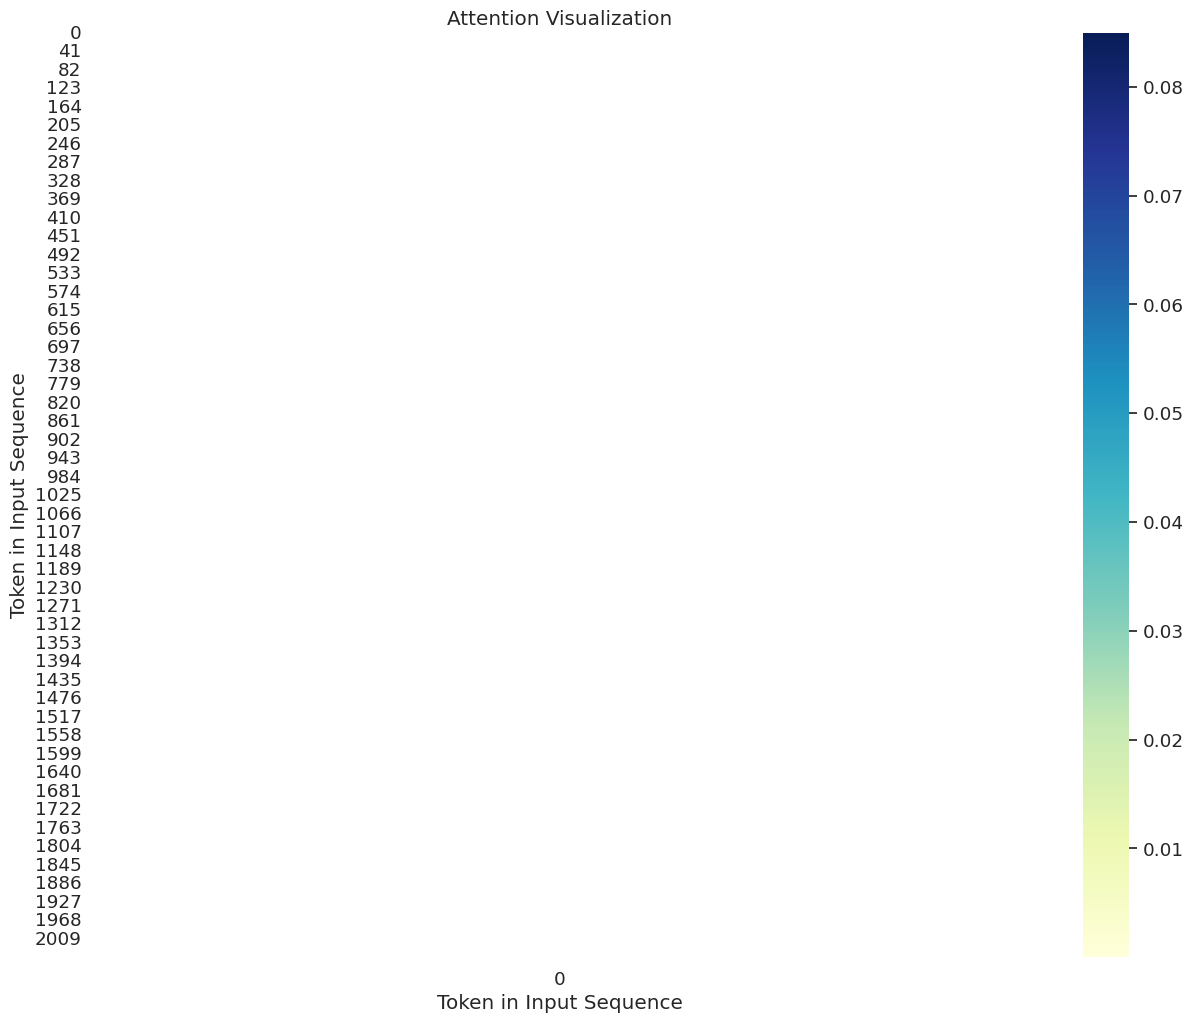

In [59]:
def visualize_attention(
    attention_weights, patient, truncate=False, only_cls=False, top_k=10
):
    # Convert attention tensor to numpy array and squeeze the batch dimension
    concept_ids = patient["concept_ids"].squeeze(0).cpu().numpy()
    attention_weights = attention_weights.squeeze(0).cpu().numpy()

    # Truncate attention weights if specified
    if truncate:
        truncate_at = patient["attention_mask"].sum().numpy()
        attention_weights = attention_weights[:, :truncate_at, :truncate_at]

    if only_cls:
        attention_weights = attention_weights[:, :, :1]

    # Average attention weights across heads
    attention_weights = attention_weights.mean(axis=0)

    # Plot the attention matrix as a heatmap
    sns.set_theme(font_scale=1.2)
    plt.figure(figsize=(15, 12))
    ax = sns.heatmap(
        attention_weights, cmap="YlGnBu", linewidths=0.5, annot=False, cbar=True
    )
    ax.set_title("Attention Visualization")
    ax.set_xlabel("Token in Input Sequence")
    ax.set_ylabel("Token in Input Sequence")

    # Print top k tokens with their attention values
    top_k_indices = np.argsort(-attention_weights, axis=None)[:top_k]
    top_k_values = attention_weights.flatten()[top_k_indices]
    top_k_indices = np.unravel_index(top_k_indices, attention_weights.shape)

    for idx in range(len(top_k_indices[0])):
        token1 = top_k_indices[0][idx]
        token2 = top_k_indices[1][idx]
        attention_value = top_k_values[idx]
        print(
            f"Token {tokenizer.id_to_token(concept_ids[token1])} "
            f"with Token {tokenizer.id_to_token(concept_ids[token2])}: "
            f"Attention Value {attention_value}"
        )

    plt.show()


# Visualize the attention matrix
visualize_attention(
    last_attention_matrix, patient=patient, truncate=True, only_cls=True, top_k=25
)

In [43]:
# Visualize REG token -> Tricky?
# Why the row vs column attention differs? -> What the matrix actually represents
# Include one example patient and visualize the attention matrix -> Include the exact concept token
# Some sort of markers to separate visits and special tokens
# Libraries used for attention visualization -> Amrit suggestion
# Visualize the gradients

'50810_3'